# Quickshift Segmentation

## Import Libraries

In [1]:
import numpy as np
import gdal
import ogr
from skimage import exposure
from skimage.segmentation import quickshift
import geopandas as gpd
import numpy as np
import scipy
import time
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from PIL import Image
from IPython.display import Image

## Open Image

In [2]:
driverTiff = gdal.GetDriverByName('GTiff')

## Open our dataset.
wellington_waterfront = gdal.Open("wellington.tif")

## Our dataset contains more than one band of data so next we get the number of bands in the
## raster using the RasterCount function.
nbands = wellington_waterfront.RasterCount

## Create an empty list.
band_data = []
print("bands", wellington_waterfront.RasterCount, 'rows', wellington_waterfront.RasterYSize, 'columns', wellington_waterfront.RasterXSize)

## Then append each raster band to that list.
for i in range(1, nbands+1):
    band = wellington_waterfront.GetRasterBand(i).ReadAsArray()
    band_data.append(band)
band_data = np.dstack(band_data)
print(band_data.shape)

bands 4 rows 1782 columns 3100
(1782, 3100, 4)


## Normalise Image

In [3]:
## Gives an image where values are now between 0 and 1
img = exposure.rescale_intensity(band_data)

## Create Segments

In [4]:
## Quickshift Segmentation:
## Parameters:
## img - our input image.
## ratio - balances color-space proximity and image-space proximity. Higher values give more weight to color-space. 
## Value has to be between 0 and 1. We chose 0.5 for an even balance between the two.
## max_dist - cut-off point for data distances. Higher (we chose a value of 20) means fewer clusters.
## convert2lab - whether the input should be converted to Lab colorspace prior to segmentation. 

segments = quickshift(img, ratio=0.5, max_dist=20, convert2lab=False)


In [5]:
np.unique(segments).shape

(2827,)

## ID for each Segment

In [6]:
## the segment_features function below calculates descriptive statistics (mean, max, min, variance) for each band. 
## These are the values that are used by the random forests algorithm to classify the segments into land cover types.

def segment_features(segment_pixels):
    features = []
    npixels, nbands = segment_pixels.shape
    
    for b in range(nbands):
        stats = scipy.stats.describe(segment_pixels[:, b])
        band_stats = list(stats.minmax) + list(stats)[2:]
        if npixels == 1:
            band_stats[3] = 0.0
        features += band_stats
    return features

In [7]:
## There are multiple cells that have the same number, this gets just the unique values and 
## groups the pixels by segment ID. 
segment_ids = np.unique(segments)

## Save to empty list
objects = []

## Save the ID of each object
object_ids = []

## Loop through all segment IDs to get all the cells that occur within a given segment
for id in segment_ids:
    segment_pixels = img[segments == id]
    object_features = segment_features(segment_pixels)
    objects.append(object_features)
    object_ids.append(id)

## Save Segments to Raster

In [8]:
segments_fn = 'segments_final.tif'

segments_ds = driverTiff.Create(segments_fn, wellington_waterfront.RasterXSize, wellington_waterfront.RasterYSize,
                                1, gdal.GDT_Float32)
segments_ds.SetGeoTransform(wellington_waterfront.GetGeoTransform())
segments_ds.SetProjection(wellington_waterfront.GetProjectionRef())
segments_ds.GetRasterBand(1).WriteArray(segments)
segments_ds = None


## Truth - Training and Test - Data (Points Generated in QGIS)

In [9]:
nrows = wellington_waterfront.RasterYSize
ncols = wellington_waterfront.RasterXSize

## Read in truth data using geopandas 
## Create GeoDataFrame (gdf)
gdf = gpd.read_file('truth_data2.shp')

## Get names for classes
class_names = gdf['LCtype'].unique()

## Print to check the classes are correct
print('class names', class_names)

## Now have a class name that corresponds to a class ID
## Create a unique id (integer) for each land cover class/label
class_ids = np.arange(class_names.size) + 1
print('class ids', class_ids)

## Save a csv file that contains this table in it that relates each class name to a class ID
df = pd.DataFrame({'label': class_names, 'id': class_ids})
df.to_csv('class_lookup.csv')


## Add a column into the shapefile that gives the ID number
gdf['id'] = gdf['LCtype'].map(dict(zip(class_names, class_ids)))
print('gdf with ids', gdf.head())


## Split the truth data into training and test data sets and save each to a new shapefile
gdf_train = gdf.sample(frac=0.7)  ## 70% of observations assigned to training data (30% to test data)
gdf_test = gdf.drop(gdf_train.index)

print('gdf shape', gdf.shape, 'training shape', gdf_train.shape, 'test. gdf_test.shape')

gdf_train.to_file('train_data.shp')
gdf_test.to_file('test_data.shp')

class names ['Water' 'Grass' 'Vegetation' 'Concrete' 'Building']
class ids [1 2 3 4 5]
gdf with ids   LCtype                         geometry  id
0  Water  POINT (1749001.117 5427878.747)   1
1  Water  POINT (1749012.782 5427904.145)   1
2  Water  POINT (1749035.922 5427880.628)   1
3  Water  POINT (1749066.022 5427863.885)   1
4  Water  POINT (1749008.831 5427838.111)   1
gdf shape (337, 3) training shape (236, 3) test. gdf_test.shape


## Rasterize Training Data

In [10]:
## Read/open the training data shapefile creted in QGIS.
train_ds = ogr.Open('train_data.shp')
## Make training dataset a layer.
lyr = train_ds.GetLayer()  


## Create a new raster layer in memory, will allow use to make a new dataset
driver = gdal.GetDriverByName('MEM') 

## New Gdal dataset of rasterised vectors.
## Create(file name blank (as in memory), x number of columns, y number of columns, nuber of bands, data type)
target_ds = driver.Create('', wellington_waterfront.RasterXSize, wellington_waterfront.RasterYSize, 1, gdal.GDT_UInt16)

## Set geotransform - tells where is space this is located relative to projection.
target_ds.SetGeoTransform(wellington_waterfront.GetGeoTransform())
target_ds.SetProjection(wellington_waterfront.GetProjection())

## Rasterize the training points
## options - when do rasterization, label raster value corrosponding ID field.
options = ['ATTRIBUTE=id']
gdal.RasterizeLayer(target_ds, [1], lyr, options=options)

## Retrieve the rasterized data and print basic stats. Check there are 5 classes.
data = target_ds.GetRasterBand(1).ReadAsArray()
print('Min =', data.min(), 'Max =', data.max())


Min = 0 Max = 5


In [11]:
## Truth data used to train model, 2D array.

ground_truth = target_ds.GetRasterBand(1).ReadAsArray()

## Get the values for each class, give unique values from ground truth.
classes = np.unique(ground_truth)[1:]
print('class values', classes)



## Find which segments belong to which class, for each class (land cover type) record the associated segment IDs.
## Which segments corrospond to which land cover type (i).
segments_per_class = {}

for i in classes:
    segments_of_class = segments[ground_truth == i]
    segments_per_class[i] = set(segments_of_class)
    print("Training segments for class", i, ":", len(segments_of_class))
    

class values [1 2 3 4 5]
Training segments for class 1 : 30
Training segments for class 2 : 31
Training segments for class 3 : 21
Training segments for class 4 : 55
Training segments for class 5 : 99


## Create Final Classified Result

In [12]:
## New array of training image.
train_img = np.copy(segments)
## Find what the maximum segment value is.
threshold = train_img.max() + 1  # make the threshold value greater than any land cover class value

## Loop through classes, each class have a label that is greater than the maximum value in the
## segmented image. Each segment assigned to ID. 
for klass in classes:
    class_label = threshold + klass
    for segment_id in segments_per_class[klass]:
        train_img[train_img == segment_id] = class_label


## Results in image where segments with no training data are classified as 0.
## Segments with training data classified with class number.
train_img[train_img <= threshold] = 0
train_img[train_img > threshold] -= threshold
        
##  Create objects and labels for training data.
training_objects = []
training_labels = []

## Find out is segment in the same dataset as class? 
for klass in classes:
    class_train_object = [v for i, v in enumerate(objects) if segment_ids[i] in segments_per_class[klass]]
    training_labels += [klass] * len(class_train_object)
    training_objects += class_train_object
        

classifier = RandomForestClassifier(n_jobs=-1)  # setup random forest classifier
classifier.fit(training_objects, training_labels)  # fit rf classifier
print('Fitting Random Forest Classifier')
predicted = classifier.predict(objects)  # predict with rf classifier
print('Predicting Classifications')


## Create numpy array from rf classification and save to raster
clf = np.copy(segments)
for segment_id, klass in zip(segment_ids, predicted):
    clf[clf == segment_id] = klass
    
print('Prediction applied to')
    
## Give 2D array with the same number of rows and columns as the image.
mask = np.sum(img, axis=2)  # this section masks no data values
mask[mask > 0.0] = 1.0
mask[mask == 0.0] = -1.0
clf = np.multiply(clf, mask)
clf[clf < 0] = -9999.0

print('Saving class classification to raster')


clfds = driverTiff.Create('classified_result1.tif', wellington_waterfront.RasterXSize, wellington_waterfront.RasterYSize,
                          1, gdal.GDT_Float32)  # this section saves to raster
clfds.SetGeoTransform(wellington_waterfront.GetGeoTransform())
clfds.SetProjection(wellington_waterfront.GetProjection())
clfds.GetRasterBand(1).SetNoDataValue(-9999.0)
clfds.GetRasterBand(1).WriteArray(clf)
clfds = None

print('Done!')

Fitting Random Forest Classifier
Predicting Classifications
Prediction applied to
Saving class classification to raster
Done!


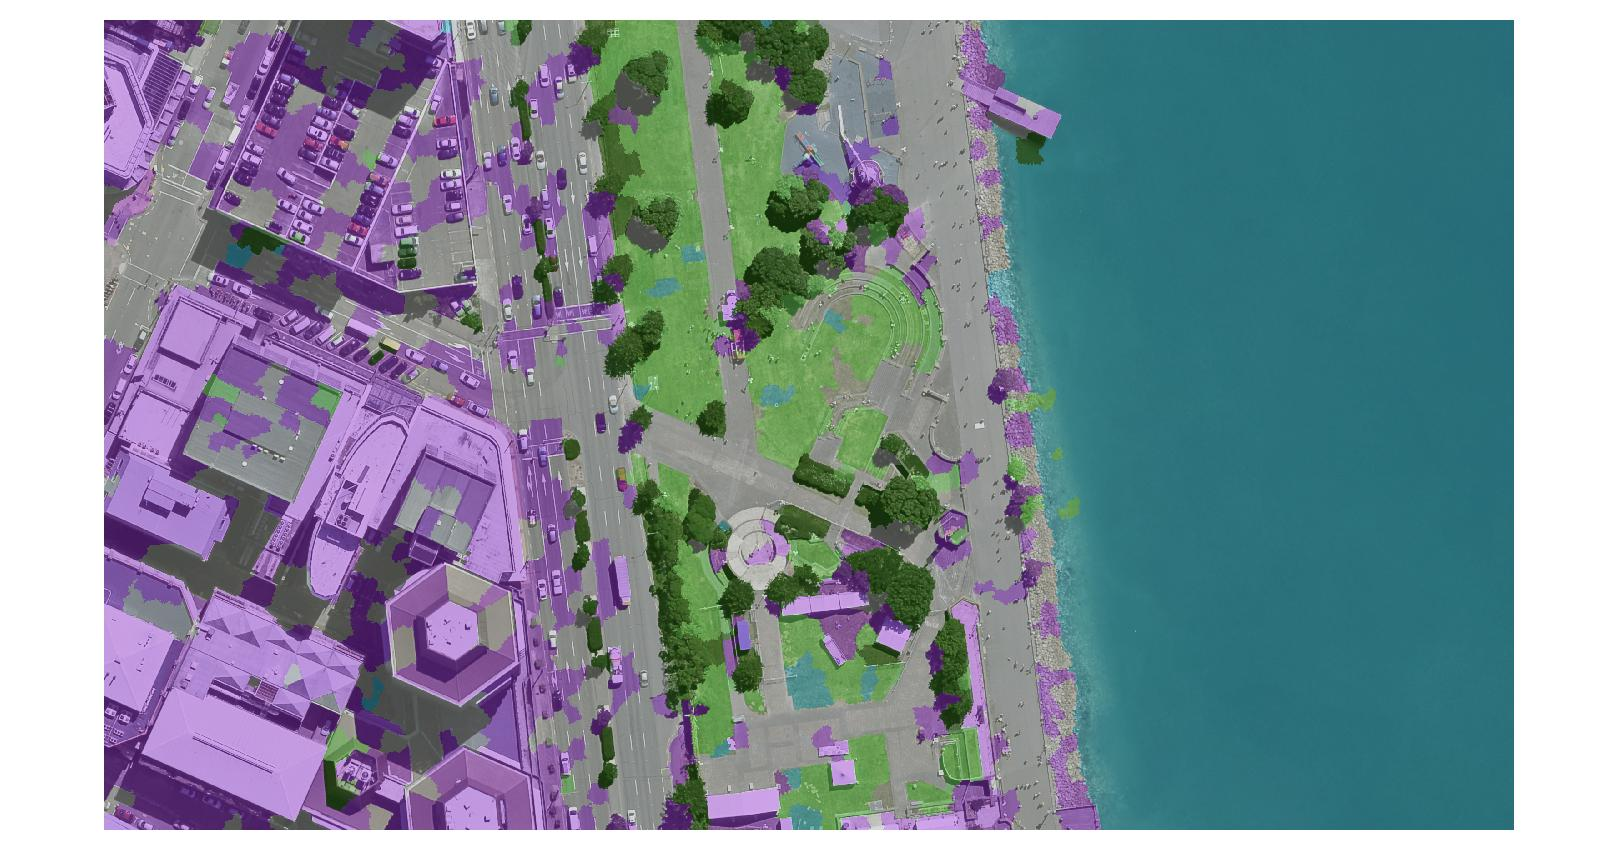

In [13]:
Image(filename='Photos/Quickshift.JPG') 